In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_dim = 20
hidden_dim = 400
batch_size = 128
num_epochs = 50
learning_rate = 1e-3

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def compute_loss(recon_x, x, mu, log_var):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD, BCE, KLD

# Training with metric collection
def train_and_collect_metrics():
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        num_batches = 0
        
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = model(data)
            total_loss, bce_loss, kld_loss = compute_loss(recon_batch, data, mu, log_var)
            
            total_loss.backward()
            optimizer.step()
            
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += bce_loss.item()
            epoch_kl_loss += kld_loss.item()
            num_batches += 1
        
        # Average losses for the epoch
        avg_total_loss = epoch_total_loss / len(mnist)
        avg_recon_loss = epoch_recon_loss / len(mnist)
        avg_kl_loss = epoch_kl_loss / len(mnist)
        
        total_losses.append(avg_total_loss)
        reconstruction_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)
    
    return model, total_losses, reconstruction_losses, kl_losses

# Train model and collect metrics
model, total_losses, reconstruction_losses, kl_losses = train_and_collect_metrics()

Training: 100%|██████████| 50/50 [02:21<00:00,  2.82s/it]


Plotting training curves...


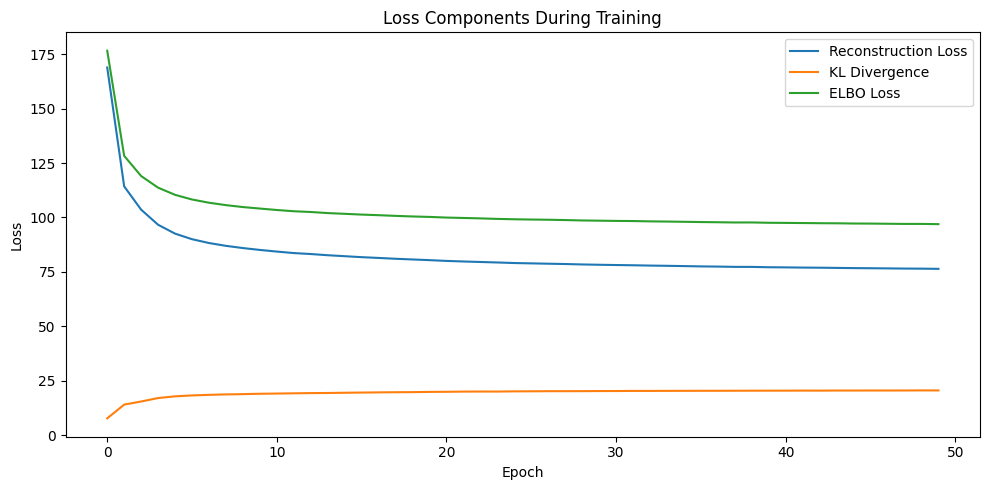

In [5]:
def plot_training_curves():
    plt.figure(figsize=(10, 5))

    # Plot loss components
    plt.plot(reconstruction_losses, label='Reconstruction Loss')
    plt.plot(kl_losses, label='KL Divergence')
    plt.plot(total_losses, label='ELBO Loss')
    plt.title('Loss Components During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate all visualizations
print("Plotting training curves...")
plot_training_curves()

In [21]:
def visualize_reconstruction_and_samples(model, num_examples=7):
    """
    Plot original, reconstructed, and generated images in a single figure
    with three rows: original, reconstructed, and generated
    """
    model.eval()
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        # Get test images
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=True)
        test_images, _ = next(iter(test_loader))
        test_images = test_images.to(device)
        
        # Generate reconstructions
        reconstructed, _, _ = model(test_images)
        reconstructed = reconstructed.view(-1, 1, 28, 28)
        
        # Generate random samples
        random_z = torch.randn(num_examples, latent_dim).to(device)
        generated = model.decode(random_z).view(-1, 1, 28, 28)
        
        # Plot original images
        for i in range(num_examples):
            plt.subplot(3, num_examples, i + 1)
            plt.imshow(test_images[i].cpu().squeeze(), cmap='gray')
            if i == 3:
                plt.title('Original')
            plt.axis('off')
        
        # Plot reconstructed images
        for i in range(num_examples):
            plt.subplot(3, num_examples, i + 1 + num_examples)
            plt.imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            if i == 3:
                plt.title('Reconstructed')
            plt.axis('off')
        
        # Plot generated images
        for i in range(num_examples):
            plt.subplot(3, num_examples, i + 1 + 2*num_examples)
            plt.imshow(generated[i].cpu().squeeze(), cmap='gray')
            if i == 3:
                plt.title('Generated')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


Visualizing reconstructions and generated images...


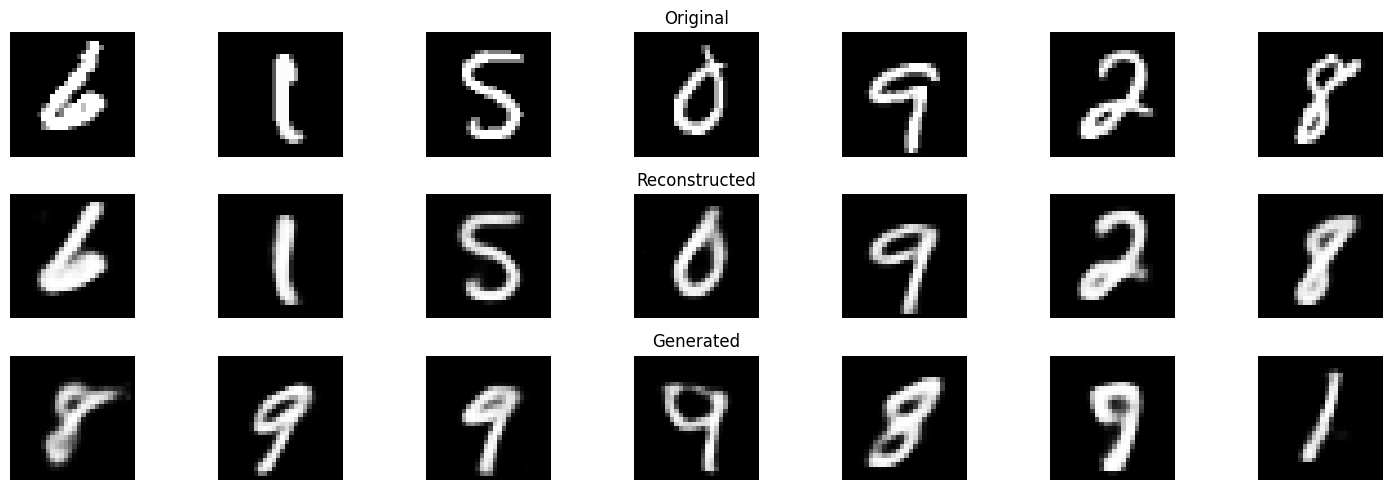

In [22]:
print("\nVisualizing reconstructions and generated images...")
visualize_reconstruction_and_samples(model)